In [1]:
###Import libraries
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn
import IPython.display as ipd
import scipy as sp
import pandas as pd
import sys
#sys.path.append('free-spoken-digit-dataset/utils')
#from trimmer import trim_silence as trs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error as mae


In [2]:
###Compute features
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)  #FILTER APPLYIANCE
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the MFCC coefficients    
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1] #first coeff (mean of pow spectrum) discarded
    return mfcc

In [3]:
###Compute training and testing features

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
n_mfcc = 13

#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0)

dict_train_features = {'zero': [], 'one': [], 'two': [], 'three': [], 'four':[], 'five':[], 'six':[], 'seven':[], 'eight':[], 'nine':[]}
dict_test_features = {'zero': [], 'one': [], 'two': [], 'three': [], 'four':[], 'five':[], 'six':[], 'seven':[], 'eight':[], 'nine':[]}



for c in classes:
    root = 'free-spoken-digit-dataset/recordings'#percorso dataset (for each class!)
    class_files = [f for f in os.listdir(root) if f.startswith(c)] #retrieve all elements in the dataset folder which starts with class' name
    #class_files = class_files[:len(class_files)//2]
    n_samples = len(class_files) #numero elementi nel dataset per la classe corrente
    
    #split dataset
    train_files, test_files = train_test_split(class_files, test_size = 0.25, random_state = 21)
    n_train_samples = len(train_files)
    n_test_samples = len(test_files)
    
    train_features = np.zeros((n_train_samples, n_mfcc)) #matrice (n_train_samples x numero di mfcc)
    test_features = np.zeros((n_test_samples, n_mfcc)) #matrice (n_test_samples x numero di mfcc)
    
    #TRAINING FEAT
    for index, f in enumerate(train_files): #for each file in train dataset
        audio, fs = librosa.load(os.path.join(root, f)) #load the current file
        mfcc = compute_mfcc(audio, fs, n_mfcc) #compute its mfcc --> take care of the size(mfcc computation requires windowing, and files are relatively long...)
        train_features[index, :] = np.mean(mfcc, axis = 1); #(...indeed, we reduce the dimension of each feature vector as (n_mfcc x 1))
    #save in dict    
    dict_train_features[c] = train_features
    
    #TESTING FEAT
    for index, f in enumerate(test_files): #for each file in train dataset
        audio, fs = librosa.load(os.path.join(root, f)) #load the current file
        mfcc = compute_mfcc(audio, fs, n_mfcc) #compute its mfcc --> take care of the size(mfcc computation requires windowing, and files are relatively long...)
        test_features[index, :] = np.mean(mfcc, axis = 1); #(...indeed, we reduce the dimension of each feature vector as (n_mfcc x 1))
    #save in dict    
    dict_test_features[c] = test_features
print(n_samples)       

300


In [4]:
#Retrieve from the dictionaries and define through concatenation one training features vector of feature vectors(the mfcc coeffs for each audio file)
X_train_0 = dict_train_features['0']
X_train_1 = dict_train_features['1']
X_train_2 = dict_train_features['2']
X_train_3 = dict_train_features['3']
X_train_4 = dict_train_features['4']
X_train_5 = dict_train_features['5']
X_train_6 = dict_train_features['6']
X_train_7 = dict_train_features['7']
X_train_8 = dict_train_features['8']
X_train_9 = dict_train_features['9']

X_train = np.concatenate((X_train_0, X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_6,
                          X_train_7, X_train_8, X_train_9), axis=0)

X_test_0 = dict_test_features['0']
X_test_1 = dict_test_features['1']
X_test_2 = dict_test_features['2']
X_test_3 = dict_test_features['3']
X_test_4 = dict_test_features['4']
X_test_5 = dict_test_features['5']
X_test_6 = dict_test_features['6']
X_test_7 = dict_test_features['7']
X_test_8 = dict_test_features['8']
X_test_9 = dict_test_features['9']
X_test = np.concatenate((X_test_0, X_test_1, X_test_2, X_test_3, X_test_4, X_test_5, X_test_6, X_test_7,
                        X_test_8, X_test_9), axis=0)
print(X_test.shape)

#define a label that will be associated with our (concatenated) training features (becero way)
y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2
y_train_3 = np.ones((X_train_3.shape[0],))*3
y_train_4 = np.ones((X_train_4.shape[0],))*4
y_train_5 = np.ones((X_train_5.shape[0],))*5
y_train_6 = np.ones((X_train_6.shape[0],))*6
y_train_7 = np.ones((X_train_7.shape[0],))*7
y_train_8 = np.ones((X_train_8.shape[0],))*8
y_train_9 = np.ones((X_train_9.shape[0],))*9
y_train = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3, y_train_4, y_train_5, y_train_6,
                         y_train_7, y_train_8, y_train_9), axis=0)

y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2
y_test_3 = np.ones((X_test_3.shape[0],))*3
y_test_4 = np.ones((X_test_4.shape[0],))*4
y_test_5 = np.ones((X_test_5.shape[0],))*5
y_test_6 = np.ones((X_test_6.shape[0],))*6
y_test_7 = np.ones((X_test_7.shape[0],))*7
y_test_8 = np.ones((X_test_8.shape[0],))*8
y_test_9 = np.ones((X_test_9.shape[0],))*9
y_test = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3, y_test_4, y_test_5, y_test_6, y_test_7,
                        y_test_8, y_test_9), axis=0)


(750, 13)


In [5]:
#We have to center and scale the data using training stats before feeding the classifier (zero mean, variance = 1) --> Ok
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
#CLASSIFICATION
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
    'random_state': 21,
}

clf = sklearn.svm.SVC(**SVM_parameters)
clf.fit(X_train_scaled, y_train)

p_train = clf.predict(X_train_scaled)
p_test = clf.predict(X_test_scaled)

mae_train = mae(y_train, p_train)
mae_test = mae(y_test,p_test)
print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')

Train MAE: 0.13777777777777778, Test MAE: 0.2


[0.992      0.98533333 0.98666667 0.98666667 0.99866667 0.996
 0.984      0.98666667 0.99333333 0.984     ]


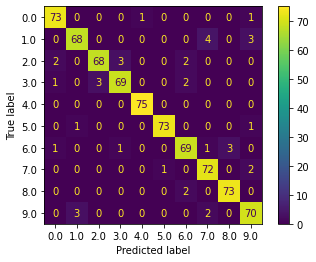

In [7]:
#See how does this classifier perform feeding it with testing dataset
cnf_matrix = confusion_matrix(y_test, p_test)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

plot_confusion_matrix(clf, X_test_scaled, y_test)
print(ACC)

In [8]:
#Optimize SVM parameters with cross validation 
#also including C = 1  and gamma = 'scale' as they are set by default
param_grid = [
    {
        'C':[0.5, 1, 10, 100],
        'gamma':['scale', 1, 0.1, 0.01, 0.001],
        'kernel': ['rbf'],
    }
]

optimal_params = GridSearchCV(
    SVC(), #classifier shell
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 0
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)



{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [9]:
#RE-TUNE SVM
SVM_parameters={
    'C': 10,
    'gamma': 0.1,
    'kernel': 'rbf',
    'random_state': 21,
}

clf = sklearn.svm.SVC(**SVM_parameters)
clf.fit(X_train_scaled, y_train)
p_train_opt = clf.predict(X_train_scaled)
p_test_opt = clf.predict(X_test_scaled)

mae_train_opt = mae(y_train, p_train_opt)
mae_test_opt = mae(y_test,p_test_opt)
print(f'Train opt MAE: {mae_train_opt}, Test opt MAE: {mae_test_opt}')

Train opt MAE: 0.013777777777777778, Test opt MAE: 0.152


[0.98666667 0.992      0.98666667 0.98533333 1.         0.996
 0.988      0.988      0.99333333 0.98533333]


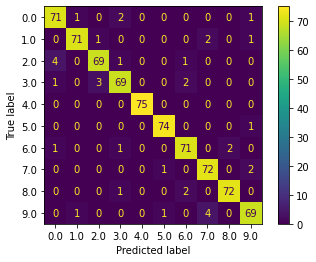

In [10]:
#Check the result
cnf_matrix = confusion_matrix(y_test, p_test_opt)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

ACC = (TP+TN)/(TP+FP+FN+TN)
plot_confusion_matrix(clf, X_test_scaled, y_test)
print(ACC)

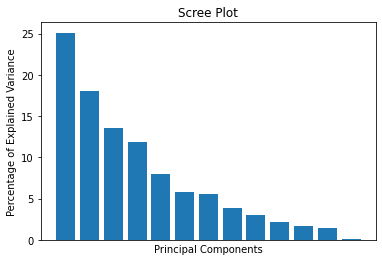

In [11]:
#we're working with 13 dimensions (1 for each feature, i.e. MFFC), so we can't plot them
#Each principal component is a linear comb of all M features (MFCC), computed with the M best fitting line in feature space
pca = PCA() #by default, it centers the data but we also have to scale them
X_test_pca = pca.fit_transform(X_test_scaled)
#How good PCA "approximation" is in describing what's going on?
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)#expl variance = SSd(nth PC) / (n_samples - 1), account the weight for each PC
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x = range(1, len(per_var)+1), height = per_var)
plt.tick_params(
    axis = 'x',
    which = 'both',
    bottom = False,
    top = False,
    labelbottom = False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()


In [12]:
#Check out what are the features that build up the most the PC1 values
mfcc_label = ['mfcc' + str(i) for i in range(1,14)]
loading_scores = pd.Series(pca.components_[0], index = mfcc_label) 
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_mfcc = sorted_loading_scores[0:12].index.values
print(loading_scores[top_mfcc])

mfcc1    -0.413911
mfcc9    -0.413616
mfcc8     0.395009
mfcc3     0.375861
mfcc5     0.368578
mfcc12   -0.318639
mfcc2    -0.188144
mfcc11    0.161578
mfcc7    -0.144557
mfcc6    -0.142695
mfcc10   -0.092862
mfcc13   -0.077041
dtype: float64


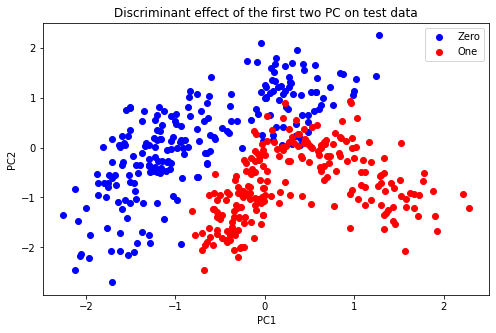

In [13]:
#2D plot using the first two PC

model = PCA(n_components = 2, whiten = True, svd_solver='auto')
model.fit(X_train_scaled)
Y = model.transform(X_train_scaled)


plt.figure(figsize=(8,5))
plt.scatter(Y[y_train==1,0], Y[y_train==1,1], c='b')
plt.scatter(Y[y_train==0,0], Y[y_train==0,1], c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Discriminant effect of the first two PC on test data')
plt.legend(('Zero', 'One'))
plt.show()

In [14]:
#Plot an instance of the SVM (just for having an example)
def draw_classplane(ax,w,xrange):
  w = model.coef_[0]
  b = model.intercept_[0]
  a = -w[0] / w[1]
  xx = np.linspace(-3, 3)
  yy = a * xx - (b/ w[1])
  margin = 1 / np.sqrt(np.sum(w** 2))
  yy_down = yy - np.sqrt(1 + a ** 2) * margin
  yy_up = yy + np.sqrt(1 + a ** 2) * margin
  ax.plot(xx, yy, 'k-')
  ax.plot(xx, yy_down, 'k--')
  ax.plot(xx, yy_up, 'k--')

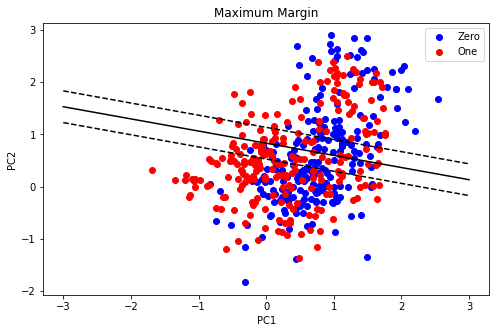

In [16]:
c_param=1
model = sklearn.svm.SVC(kernel='linear', C=c_param)
model.fit(X_train_scaled,y_train)
labels=model.predict(X_train_scaled)

plt.figure(figsize=(8,5))
plt.scatter(X_train_scaled[labels==1,0],X_train_scaled[labels==1,1], c='b')
plt.scatter(X_train_scaled[labels==0,0], X_train_scaled[labels==0,1], c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Maximum Margin')
plt.legend(('Zero', 'One'))


draw_classplane(plt.gca(), model.coef_[0], (0,1))